<a href="https://colab.research.google.com/github/dhanavishnu13/Satellite_Image_Segmentation_Using_U-Net_model/blob/main/Q2_Drone_Image_Segmentation_with_gradio.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Deployed in Huggingface Spaces](https://huggingface.co/spaces/vishnu23/drone_image_segmentation)

In [ ]:
#Step1: Install Required Packages
!pip install gradio

In [ ]:
#Step2: Import packages and libraries
import os
import cv2
from PIL import Image
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Conv2DTranspose
from keras.layers import concatenate, BatchNormalization, Dropout, Lambda
from keras import backend as K
from matplotlib import pyplot as plt
from tensorflow.keras.utils import to_categorical
import geopandas as gpd
import matplotlib.pyplot as plt
from google.colab import drive
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from google.colab.patches import cv2_imshow
import geopandas as gpd
from skimage.measure import regionprops, label
from shapely.geometry import Polygon
import shutil

In [ ]:
#Step3: Connecting to dataset source

drive.mount('/content/drive')
# data_dir = 'drive/MyDrive/Building_footprint_dataset'

Mounted at /content/drive


In [ ]:
#Step4: Patchify

def preprocess_image(image_path):
    img = cv2.imread(image_path)
    img = cv2.resize(img, (256, 256))
    img = img.astype(np.float32) / 255.0
    return img

def preprocess_mask(mask_path):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.resize(mask, (256, 256))
    mask = (mask > 0).astype(np.float32)
    return mask

images = []
masks = []
images_path = os.path.join('drive/MyDrive/Building_footprint_dataset/png/train')
masks_path = os.path.join('drive/MyDrive/Building_footprint_dataset/png/train_labels')

for filename in os.listdir(images_path):
    image_path = os.path.join(images_path, filename)
    mask_path = os.path.join(masks_path, filename)
    images.append(preprocess_image(image_path))
    masks.append(preprocess_mask(mask_path))

In [ ]:
#Step5: Encoding output classes
X_train = np.array(images)
y_train = np.array(masks)
y_train = to_categorical(y_train, num_classes=2)

In [ ]:
#Step 6: Building the U-Net model
def multi_unet_model(n_classes=2, image_height=256, image_width=256, image_channels=3):

  inputs = Input((image_height, image_width, image_channels))

  source_input = inputs

  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(source_input)
  c1 = Dropout(0.2)(c1)
  c1 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c1)
  p1 = MaxPooling2D((2,2))(c1)

  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p1)
  c2 = Dropout(0.2)(c2)
  c2 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c2)
  p2 = MaxPooling2D((2,2))(c2)

  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p2)
  c3 = Dropout(0.2)(c3)
  c3 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c3)
  p3 = MaxPooling2D((2,2))(c3)

  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p3)
  c4 = Dropout(0.2)(c4)
  c4 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c4)
  p4 = MaxPooling2D((2,2))(c4)

  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(p4)
  c5 = Dropout(0.2)(c5)
  c5 = Conv2D(256, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c5)

  u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding="same")(c5)
  u6 = concatenate([u6, c4])
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u6)
  c6 = Dropout(0.2)(c6)
  c6 = Conv2D(128, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c6)

  u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding="same")(c6)
  u7 = concatenate([u7, c3])
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u7)
  c7 = Dropout(0.2)(c7)
  c7 = Conv2D(64, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c7)

  u8 = Conv2DTranspose(32, (2,2), strides=(2,2), padding="same")(c7)
  u8 = concatenate([u8, c2])
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u8)
  c8 = Dropout(0.2)(c8)
  c8 = Conv2D(32, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c8)

  u9 = Conv2DTranspose(16, (2,2), strides=(2,2), padding="same")(c8)
  u9 = concatenate([u9, c1], axis=3)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(u9)
  c9 = Dropout(0.2)(c9)
  c9 = Conv2D(16, (3,3), activation="relu", kernel_initializer="he_normal", padding="same")(c9)

  outputs = Conv2D(n_classes, (1,1), activation="sigmoid")(c9)

  model = Model(inputs=[inputs], outputs=[outputs])
  return model

In [ ]:
#Step 7: Model Compilation
model = multi_unet_model()
model.compile(optimizer='adam', loss='binary_crossentropy',metrics='accuracy')
model.fit(X_train, y_train, epochs=50, batch_size=5)
model.save('drive/My Drive/building_footprint_extraction_model.h5')
model.save('drive/My Drive/building_footprint_extraction_model.keras')

In [ ]:
# model = load_model('drive/My Drive/building_footprint_extraction_model.h5')
model = load_model('/content/drive/MyDrive/Colab Notebooks/building_footprint_extraction_model.h5')
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 256, 256, 16  448         ['input_5[0][0]']                
                                )                                                                 
                                                                                                  
 dropout_36 (Dropout)           (None, 256, 256, 16  0           ['conv2d_76[0][0]']              
                                )                                                           

1/1 [==============================] - 10s 10s/step


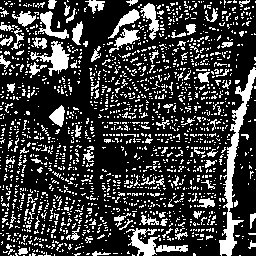

True

In [ ]:
#Step 8: Model Prediction
img = load_img('/content/23429080_15.png', target_size=(256, 256))
img_array = img_to_array(img)
img_array = img_array.reshape((1, 256, 256, 3))
img_array = img_array / 255.0
predictions = model.predict(img_array)
predicted_image = np.argmax(predictions, axis=3)
predicted_image = predicted_image[0,:,:]
predicted_image = predicted_image * 255
cv2_imshow(predicted_image)
cv2.imwrite('output.jpg',predicted_image)

In [ ]:
threshold = 0.5
binary_mask = (predictions > threshold).astype(np.uint8)[:, :, 1]
if np.sum(binary_mask) == 0:
    print("No building pixels detected. Saving an empty shapefile.")
else:
    labeled_mask = label(binary_mask)
    building_polygons = []
    props = regionprops(labeled_mask)
    for prop in props:
        polygon = Polygon([(point[1], point[0]) for point in prop.coords])
        building_polygons.append(polygon)
    gdf = gpd.GeoDataFrame(geometry=building_polygons, crs="EPSG:4326")
    output_shapefile = "shapefiles/building_footprints.shp"
    if os.path.exists('shapefiles'):
      pass
    else:
      os.mkdir('shapefiles')
    gdf.to_file(output_shapefile)
    cv2.imwrite('shapefiles/mask.jpg',predicted_image)
    shutil.make_archive('shapefile', 'zip', 'shapefiles')

In [ ]:
shapefile_path = "/content/building_footprints.shp"
gdf = gpd.read_file(shapefile_path)
gdf.head()

Buliding Gradio

In [ ]:
!pip install gradio

In [ ]:
import os
import cv2
from PIL import Image
import numpy as np
from keras import backend as K
import geopandas as gpd
import matplotlib.pyplot as plt
# from google.colab import drive
from keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import geopandas as gpd
from skimage.measure import regionprops, label
from shapely.geometry import Polygon
import shutil
import gradio as gr

def predict(img):
    # model = load_model('drive/My Drive/building_footprint_extraction_model.h5')
    model = load_model('model/building_footprint_extraction_model.h5')
    img_array = img_to_array(img)
    img_array = img_array.reshape((1, 256, 256, 3))
    img_array = img_array / 255.0
    predictions = model.predict(img_array)
    predicted_image = np.argmax(predictions, axis=3)
    predicted_image = predicted_image[0,:,:]
    predicted_image = predicted_image * 255
    return predictions,predicted_image

def get_shape_files(img):
  predictions,predicted_image= predict(img)
  threshold = 0.5
  binary_mask = (predictions > threshold).astype(np.uint8)[:, :, 1]
  if np.sum(binary_mask) == 0:
      print("No building pixels detected. Saving an empty shapefile.")
  else:
      labeled_mask = label(binary_mask)
      building_polygons = []
      props = regionprops(labeled_mask)
      for prop in props:
          polygon = Polygon([(point[1], point[0]) for point in prop.coords])
          building_polygons.append(polygon)
      gdf = gpd.GeoDataFrame(geometry=building_polygons, crs="EPSG:4326")
      output_shapefile = "shapefiles/building_footprints.shp"
      if os.path.exists('shapefiles'):
        pass
      else:
        os.mkdir('shapefiles')
      gdf.to_file(output_shapefile)

      # To get Masked Image
      cv2.imwrite('shapefiles/mask.jpg',predicted_image)
      shutil.make_archive('shapefile', 'zip', 'shapefiles')
      return 'shapefile.zip',predicted_image

my_app = gr.Blocks()
with my_app:
  gr.Markdown("<center><h1>Building Footprint Extraction</h1></center>")
  with gr.Tabs():
    # with gr.TabItem("Get Mask Image"):
    #   with gr.Row():
    #     with gr.Column():
    #         img_source = gr.Image(label="Please select source Image", shape=(256, 256))
    #         source_image_loader = gr.Button("Load above Image")
    #     with gr.Column():
    #         img_output = gr.Image(label="Image Output")
    # source_image_loader.click(predict,img_source,[img_output])
    with gr.TabItem("Get Mask Image and Shapefiles"):
      with gr.Row():
        with gr.Column():
            img_source = gr.Image(label="Please select source Image", shape=(256, 256))
            get_shape_loader = gr.Button("Get Shape File")

        with gr.Column():
          with gr.Row():
              mask_img=gr.Image(label="Image Output")
          with gr.Row():
            output_zip = gr.outputs.File()

    get_shape_loader.click(get_shape_files,img_source,[output_zip,mask_img])
my_app.launch(debug = True)